In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

from NN_jax import *

import jPCA

In [31]:
def get_reg(X_train,y_train,X_test, y_test):
    regr = RidgeCV()
    reg = regr.fit(X_train, y_train)   
    return reg.score(X_test, y_test), reg.predict(X_test)   

def get_r2_results(behaviour, ds, split = 10, lag = 5): 
    y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
    y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])

    ls_r2_ksca = []
    ls_su_ksca = []
    ls_r2_sca = []
    ls_su_sca = []
    ls_r2_pca = []
    ls_su_pca = []
    ls_traces_ksca = []
    ls_traces_sca = []
    ls_traces_pca = []
    ls_principal_angle_kSCA_SCA = []
    ls_principal_angle_kSCA_PCA = []
    ls_principal_angle_SCA_PCA = []
    for d in ds:
        Y_kSCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_gaussian.npy")
        #Y_kSCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/neural_spikes/projection_{d}d_gaussian.npy")
        X_train = Y_kSCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_kSCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)

        ls_r2_ksca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_ksca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_ksca.append( compute_S_all_pairs(jnp.array(Y_kSCA)))

        Y_SCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_linear.npy")
        #Y_SCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/neural_spikes/projection_{d}d_linear.npy")
        X_train = Y_SCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_SCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_sca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_sca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_sca.append( compute_S_all_pairs(jnp.array(Y_SCA)))

        Y_PCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/Y_pca_{d}d.npy")
        #Y_PCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_spikes/Y_pca_{d}d_spikes.npy")
        X_train = Y_PCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_PCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_pca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_pca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_pca.append( compute_S_all_pairs(jnp.array(Y_PCA)))


        Q_Y_kSCA, _ = qr(Y_kSCA.swapaxes(1,2).reshape(-1,d))
        Q_Y_SCA, _ = qr(Y_SCA.swapaxes(1,2).reshape(-1,d))
        Q_Y_PCA, _ = qr(Y_PCA.swapaxes(1,2).reshape(-1,d))
        ls_principal_angle_kSCA_SCA.append( np.rad2deg(subspace_angles(Q_Y_kSCA, Q_Y_SCA))[-1] )
        ls_principal_angle_kSCA_PCA.append( np.rad2deg(subspace_angles(Q_Y_kSCA, Q_Y_PCA))[-1] )
        ls_principal_angle_SCA_PCA.append( np.rad2deg(subspace_angles(Q_Y_SCA, Q_Y_PCA))[-1] )


    X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
    #X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)
    X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
    X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
    r2_X = get_reg(X_train,y_train,X_test, y_test)[0]
    return ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ls_principal_angle_kSCA_SCA, ls_principal_angle_kSCA_PCA, ls_principal_angle_SCA_PCA, ls_traces_ksca, ls_traces_sca, ls_traces_pca

def get_r2_plots(title, ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ds):
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    axs[0].plot(ls_r2_ksca, label='kSCA')
    axs[0].plot(ls_r2_sca, label='kSCA')
    axs[0].plot(ls_r2_pca, label='PCA')
    axs[0].set_title(title)

    axs[0].axhline(r2_X, color='black', linestyle='--')
    axs[0].set_ylabel(r"$R^2$")

    axs[1].plot(ls_su_ksca, label='kSCA')
    axs[1].plot(ls_su_sca, label='SCA')
    axs[1].plot(ls_su_pca, label='PCA')
    axs[1].set_ylabel(r"$S[\phi(U)]$")

    data_length = len(ds) 
    tick_positions = np.linspace(0, data_length - 1, num=len(ds)) 
    tick_labels = ds
    for ax in axs:
        ax.set_xlabel(r"$d$")
        ax.set_xticks(tick_positions, tick_labels)
        ax.grid()
        ax.spines[['right', 'top']].set_visible(False)

    plt.legend()
    #plt.suptitle(title)



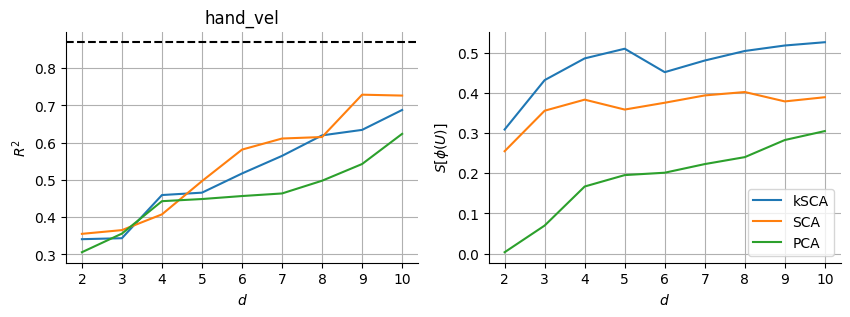

In [32]:
split = 10
lag = 5

ds = np.arange(2,11)
#ds = [2, 3, 6]
#path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_behavior.npy' #.swapaxes(1,2)

path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/hand_vel.npy'
behaviour = np.load(path)
ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ls_principal_angle_kSCA_SCA, ls_principal_angle_kSCA_PCA, ls_principal_angle_SCA_PCA, ls_traces_ksca, ls_traces_sca, ls_traces_pca = get_r2_results(behaviour, ds)
get_r2_plots('hand_vel', ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ds)

In [12]:
K, _, T = behaviour.shape
y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])

y_test_reshaped = y_test.reshape(split,T-lag,-1)                    #(K[test], T_lag, N)
traces_sca_reshaped = ls_traces_sca[-1].reshape(split,T-lag,-1)
print(y_test_reshaped.shape)

NameError: name 'ls_traces_sca' is not defined

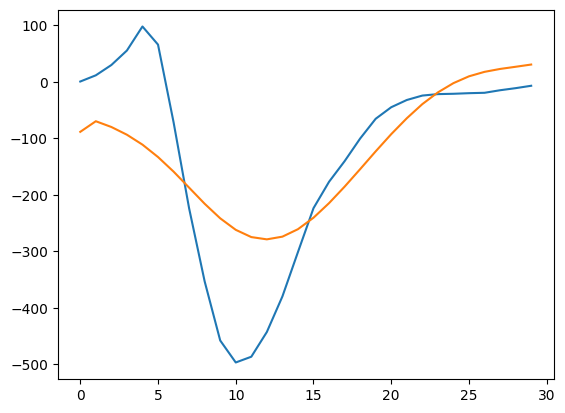

In [64]:
plt.plot(y_test_reshaped[5,:,-1])
plt.plot(traces_sca_reshaped[5,:,-1])

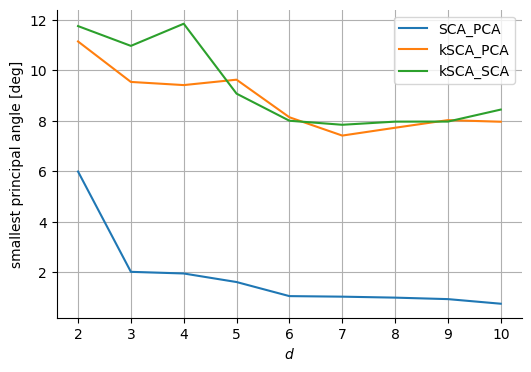

In [7]:
ds = np.arange(2, 11)
data_length = len(ds)
tick_positions = np.linspace(0, data_length - 1, num=9)
tick_labels = ds

fig, ax = plt.subplots(figsize=(6,4))  
ax.plot(ls_principal_angle_SCA_PCA, label='SCA_PCA') 
ax.plot(ls_principal_angle_kSCA_PCA, label='kSCA_PCA')
ax.plot(ls_principal_angle_kSCA_SCA, label='kSCA_SCA')

ax.legend() 
ax.set_xticks(tick_positions)  
ax.set_xticklabels(tick_labels) 
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('smallest principal angle [deg]')
ax.set_xlabel(r"$d$")
ax.grid()

Neural Network Predictions

<Figure size 640x480 with 0 Axes>

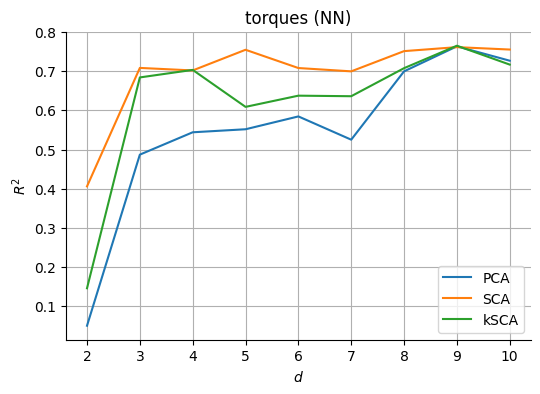

In [2]:
def get_R2_nonlinear(behaviour, ds):
    ls_r2_ksca = []
    ls_r2_sca = []
    ls_r2_pca = []
    for d in ds:
        ls_r2_ksca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/{behaviour}/gaussian_{d}_r2 .npy'))
        ls_r2_sca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/{behaviour}/linear_{d}_r2 .npy'))
        ls_r2_pca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/{behaviour}/pca_{d}_r2 .npy'))


    data_length = len(ds)
    tick_positions = np.linspace(0, data_length - 1, num=9)
    tick_labels = ds

    plt.figure()
    fig, ax = plt.subplots(figsize=(6,4))  
    ax.plot(ls_r2_pca, label='PCA') 
    ax.plot(ls_r2_sca, label='SCA') 
    ax.plot(ls_r2_ksca, label='kSCA') 

    ax.legend() 
    ax.set_xticks(tick_positions)  
    ax.set_xticklabels(tick_labels) 
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel(r"$R^2$")
    ax.set_xlabel(r"$d$")
    ax.set_title(f'{behaviour} (NN)')
    ax.grid()

ds = np.arange(2,11)
#get_R2_nonlinear('hand_vel', ds)
get_R2_nonlinear('torques', ds)

ENDS HERE 

In [4]:
split = 10 
lag = 5


behaviour = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/hand_vel.npy')
y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])


X = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_3d_gaussian.npy")
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])


print(np.array(get_reg(X_train,y_train,X_test, y_test)[0]))

# X = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_10d_linear.npy")
# X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
# X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])

# print(get_reg(X_train,y_train,X_test, y_test)[0])

0.34349564963510254


In [5]:
params, ls_loss = optimize(X_train, y_train, layer_sizes = [3, 10, 2], num_iterations = 10000, seed=42, learning_rate = 1e-3)

Iter 1, Loss: 80138.6172
Iter 11, Loss: 80138.2656
Iter 21, Loss: 80137.8203
Iter 31, Loss: 80137.2344
Iter 41, Loss: 80136.4766
Iter 51, Loss: 80135.5078
Iter 61, Loss: 80134.3203
Iter 71, Loss: 80132.8750
Iter 81, Loss: 80131.2031
Iter 91, Loss: 80129.2734
Iter 101, Loss: 80127.1016
Iter 111, Loss: 80124.6641
Iter 121, Loss: 80121.9688
Iter 131, Loss: 80119.0312
Iter 141, Loss: 80115.8125
Iter 151, Loss: 80112.3516
Iter 161, Loss: 80108.6328
Iter 171, Loss: 80104.6641
Iter 181, Loss: 80100.4297
Iter 191, Loss: 80095.9375
Iter 201, Loss: 80091.2109
Iter 211, Loss: 80086.2266
Iter 221, Loss: 80080.9922
Iter 231, Loss: 80075.4922
Iter 241, Loss: 80069.7656
Iter 251, Loss: 80063.7812
Iter 261, Loss: 80057.5703
Iter 271, Loss: 80051.1172
Iter 281, Loss: 80044.4062
Iter 291, Loss: 80037.4688
Iter 301, Loss: 80030.2891
Iter 311, Loss: 80022.8594
Iter 321, Loss: 80015.2031
Iter 331, Loss: 80007.3125
Iter 341, Loss: 79999.1953
Iter 351, Loss: 79990.8438
Iter 361, Loss: 79982.2734
Iter 371, Lo

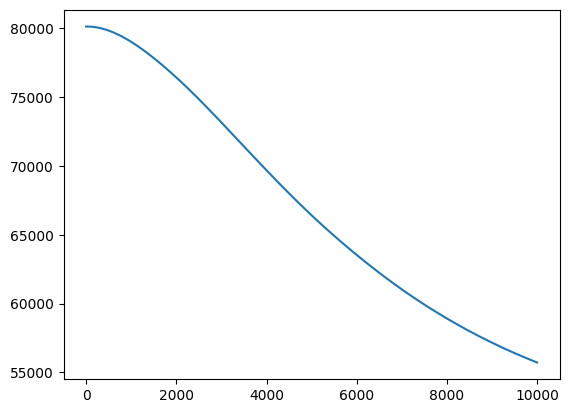

In [6]:
plt.plot(ls_loss)

In [42]:
predictions = predict(params, X_test)
r2_score(y_test, predictions)

0.47027373371449954

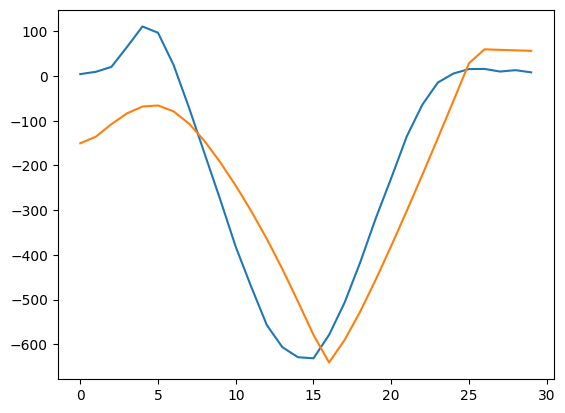

In [23]:
T=35
y_test_reshaped = y_test.reshape(split,T-lag,-1)                    #(K[test], T_lag, N)
pred_reshaped = predictions.reshape(split,T-lag,-1)

plt.plot(y_test_reshaped[7,:,0])
plt.plot(pred_reshaped[7,:,0])